In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
#import data
observation_file = '../data/FHN_Data/observations.csv'
time_file = '../data/FHN_Data/time.csv'
XInit_file = '../data/FHN_Data/XInit.csv'


#import Observations, 2 states perturbed by noise, sliced as y0, y1
Y = np.genfromtxt(observation_file)
y0 = Y[:, 0]
y1 = Y[:, 1]

#import Time
t = np.genfromtxt(time_file)

#import XInit
XInit = np.genfromtxt(XInit_file)
x0_init = XInit[0]
x1_init = XInit[1]




In [5]:
#Check Data shape
print('y0:', y0.shape)
print('y1:', y1.shape)
print('t:', t.shape)
print('XInit:', XInit.shape)


y0: (41,)
y1: (41,)
t: (41,)
XInit: (2,)


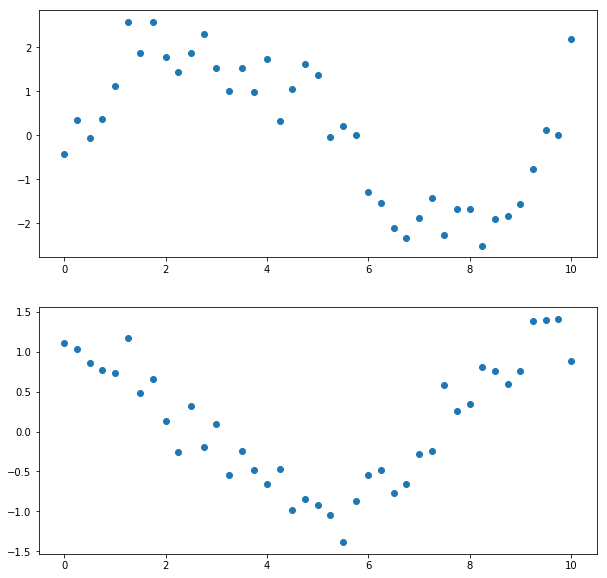

In [6]:
# Data visualization
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(t, y0)
ax2.scatter(t, y1)

In [10]:
train_t = torch.from_numpy(t)
train_y0 = torch.from_numpy(y0)
train_y1 = torch.from_numpy(y1)

#train_x

In [11]:
# We will use the simplest form of GP model, exact inference

#RBF Kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#Mattern Kernel

class GP_Matern(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP_Mattern, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [14]:
# initialize likelihood and model(RBF)
likelihood_y0_t = gpytorch.likelihoods.GaussianLikelihood()
model_y0_t = ExactGPModel(train_t, train_y0, likelihood_y0_t)


likelihood_y1_t = gpytorch.likelihoods.GaussianLikelihood()
model_y1_t = ExactGPModel(train_t, train_y1, likelihood_y1_t)



In [15]:
# Find optimal model hyperparameters for GP0(t)
model_y0_t.train() # ????
likelihood_y0_t.train()  # ????

model_y0_t.double()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model_y0_t.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood  # ????
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_y0_t, model_y0_t)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_y0_t(train_t)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y0)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_y0_t.covar_module.base_kernel.log_lengthscale.item(),
        model_y0_t.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.358   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 1.310   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/50 - Loss: 1.274   log_lengthscale: 0.185   log_noise: -0.200
Iter 4/50 - Loss: 1.260   log_lengthscale: 0.238   log_noise: -0.299
Iter 5/50 - Loss: 1.256   log_lengthscale: 0.245   log_noise: -0.398
Iter 6/50 - Loss: 1.225   log_lengthscale: 0.253   log_noise: -0.496
Iter 7/50 - Loss: 1.194   log_lengthscale: 0.247   log_noise: -0.593
Iter 8/50 - Loss: 1.185   log_lengthscale: 0.245   log_noise: -0.690
Iter 9/50 - Loss: 1.173   log_lengthscale: 0.231   log_noise: -0.786
Iter 10/50 - Loss: 1.151   log_lengthscale: 0.215   log_noise: -0.880
Iter 11/50 - Loss: 1.144   log_lengthscale: 0.200   log_noise: -0.973
Iter 12/50 - Loss: 1.113   log_lengthscale: 0.181   log_noise: -1.063
Iter 13/50 - Loss: 1.107   log_lengthscale: 0.152   log_noise: -1.150
Iter 14/50 - Loss: 1.082   log_lengthscale: 0.125   log_noise: -1.236
Iter 15/50 - Loss: 1.125   log

In [16]:
# Get into evaluation (predictive posterior) mode
model_y0_t.eval()
likelihood_y0_t.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.fast_pred_var():   # ????
    test_t = train_t
    observed_pred = likelihood_y0_t(model_y0_t(test_t))

/anaconda3/envs/gpytorch/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:89: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


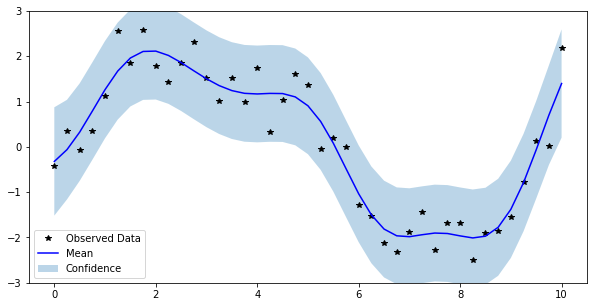

In [17]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_t.numpy(), train_y0.numpy(), 'k*')
    # Plot predictive means as blue line
    #ax.plot(test_t.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(test_t.numpy(), model_y0_t(test_t).mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_t.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [18]:
# Find optimal model hyperparameters for  GP1(t)
model_y1_t.train() # ????
likelihood_y1_t.train()  # ????

model_y1_t.double()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model_y1_t.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood  # ????
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_y1_t, model_y1_t)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_y1_t(train_t)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y1)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_y1_t.covar_module.base_kernel.log_lengthscale.item(),
        model_y1_t.likelihood.log_noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.156   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 1.089   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/50 - Loss: 1.037   log_lengthscale: 0.200   log_noise: -0.200
Iter 4/50 - Loss: 0.999   log_lengthscale: 0.299   log_noise: -0.300
Iter 5/50 - Loss: 0.953   log_lengthscale: 0.399   log_noise: -0.400
Iter 6/50 - Loss: 0.899   log_lengthscale: 0.499   log_noise: -0.500
Iter 7/50 - Loss: 0.851   log_lengthscale: 0.597   log_noise: -0.600
Iter 8/50 - Loss: 0.811   log_lengthscale: 0.691   log_noise: -0.700
Iter 9/50 - Loss: 0.770   log_lengthscale: 0.779   log_noise: -0.800
Iter 10/50 - Loss: 0.735   log_lengthscale: 0.861   log_noise: -0.900
Iter 11/50 - Loss: 0.701   log_lengthscale: 0.930   log_noise: -0.999
Iter 12/50 - Loss: 0.669   log_lengthscale: 0.979   log_noise: -1.099
Iter 13/50 - Loss: 0.635   log_lengthscale: 1.008   log_noise: -1.198
Iter 14/50 - Loss: 0.600   log_lengthscale: 1.006   log_noise: -1.297
Iter 15/50 - Loss: 0.563   log

In [19]:
# Get into evaluation (predictive posterior) mode
model_y1_t.eval()
likelihood_y1_t.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.fast_pred_var():   # ????
    test_t = train_t
    observed_pred = likelihood_y1_t(model_y1_t(test_t))

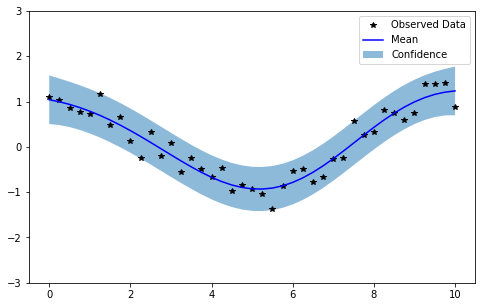

In [20]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_t.numpy(), train_y1.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_t.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_t.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

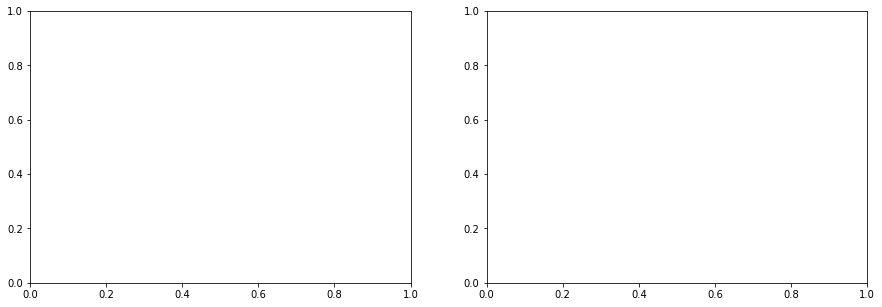

In [22]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_t.numpy(), train_y0.numpy(), 'k*')
    # Plot predictive means as blue line
    #ax.plot(test_t.numpy(), observed_pred.mean.numpy(), 'b')
    ax.plot(test_t.numpy(), model_y0_t(test_t).mean.numpy(), 'b')
    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_t.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])